In [9]:
# -*- coding:utf-8 -*-
import os
import cv2
import time
import argparse

import numpy as np
from PIL import Image
#from keras.models import model_from_json
from utils.anchor_generator import generate_anchors
from utils.anchor_decode import decode_bbox
from utils.nms import single_class_non_max_suppression
from load_model.tensorflow_loader import load_tf_model, tf_inference

In [10]:
os.environ['CUDA_VISIBLE_DEVICES']=''  # if you do  have gpu, set it to '0' or you GPU number

In [11]:
sess, graph = load_tf_model('models/face_mask_detection.pb')
# anchor configuration
feature_map_sizes = [[33, 33], [17, 17], [9, 9], [5, 5], [3, 3]]
anchor_sizes = [[0.04, 0.056], [0.08, 0.11], [0.16, 0.22], [0.32, 0.45], [0.64, 0.72]]
anchor_ratios = [[1, 0.62, 0.42]] * 5

# generate anchors
anchors = generate_anchors(feature_map_sizes, anchor_sizes, anchor_ratios)

# for inference , the batch size is 1, the model output shape is [1, N, 4],
# so we expand dim for anchors to [1, anchor_num, 4]
anchors_exp = np.expand_dims(anchors, axis=0)

id2class = {0: 'Mask', 1: 'NoMask'}

In [12]:
def inference(image,
              conf_thresh=0.5,
              iou_thresh=0.4,
              target_shape=(160, 160),
              draw_result=True,
              ):
    '''
    Main function of detection inference
    :param image: 3D numpy array of image
    :param conf_thresh: the min threshold of classification probabity.
    :param iou_thresh: the IOU threshold of NMS
    :param target_shape: the model input size.
    :param draw_result: whether to daw bounding box to the image.
    :param show_result: whether to display the image.
    :return:
    '''
    # image = np.copy(image)
    output_info = []
    height, width, _ = image.shape
    image_resized = cv2.resize(image, target_shape)
    image_np = image_resized / 255.0  # 归一化到0~1
    image_exp = np.expand_dims(image_np, axis=0)
    y_bboxes_output, y_cls_output = tf_inference(sess, graph, image_exp)

    # remove the batch dimension, for batch is always 1 for inference.
    y_bboxes = decode_bbox(anchors_exp, y_bboxes_output)[0]
    y_cls = y_cls_output[0]
    # To speed up, do single class NMS, not multiple classes NMS.
    bbox_max_scores = np.max(y_cls, axis=1)
    bbox_max_score_classes = np.argmax(y_cls, axis=1)

    # keep_idx is the alive bounding box after nms.
    keep_idxs = single_class_non_max_suppression(y_bboxes,
                                                 bbox_max_scores,
                                                 conf_thresh=conf_thresh,
                                                 iou_thresh=iou_thresh,
                                                 )

    for idx in keep_idxs:
        conf = float(bbox_max_scores[idx])
        class_id = bbox_max_score_classes[idx]
        bbox = y_bboxes[idx]
        # clip the coordinate, avoid the value exceed the image boundary.
        xmin = max(0, int(bbox[0] * width))
        ymin = max(0, int(bbox[1] * height))
        xmax = min(int(bbox[2] * width), width)
        ymax = min(int(bbox[3] * height), height)

        if draw_result:
            if class_id == 0:
                color = (0, 255, 0)
            else:
                color = (255, 0, 0)
            cv2.rectangle(image, (xmin, ymin), (xmax, ymax), color, 2)
            cv2.putText(image, "%s: %.2f" % (id2class[class_id], conf), (xmin + 2, ymin - 2),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.8, color)
        output_info.append([class_id, conf, xmin, ymin, xmax, ymax])

    img_output = Image.fromarray(image)
    return output_info, img_output

In [13]:
imgPath = 'img/demo2.jpg'
img = cv2.imread(imgPath)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
output_info, img_output = inference(img, draw_result=True, target_shape=(260, 260))

In [14]:
output_info

[[0, 0.9071263074874878, 222, 49, 327, 198]]

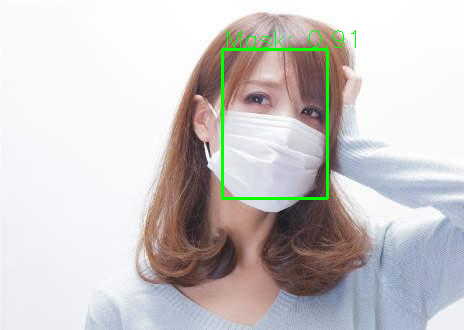

In [15]:
img_output